In [1]:
# Please run this notebook in python version >= '3.5'
# All imports required to run the code

import abc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pathlib

%matplotlib inline

In [2]:
# All CONSTANTS used in the notebook

# Download URLs
# Image credits and rights belong to the owner of image.
# Images are just used for academic purposes. 
# http://sipi.usc.edu/database/download.php?vol=misc&img=5.1.12

# Set the path to the images
PATH = pathlib.Path('~/Downloads').expanduser()
PATH1 = PATH / '5.1.12.tiff'

In [3]:
# Utility functions

def linear_point_transform(image: np.ndarray, scale: int = 1, offset: int = 0):
    """Performs FCFS(Full Scale Contrast Stretch)

    Returns: `np.ndarray`, Image after transformation.    
    """
    return np.clip(image * scale + offset, MIN_PIXEL_VALUE, MAX_PIXEL_VALUE).astype(int)

def get_fscs_scale_offset(image: np.ndarray):
    """Get FCFS scaling factor and offset"""
    max_val, min_val = np.max(image), np.min(image)
    scale = MAX_PIXEL_VALUE / (max_val - min_val)
    offset = - min_val * MAX_PIXEL_VALUE / (max_val - min_val)
    return (scale, offset)

def log_transform(image: np.ndarray):
    """Perform Log Range Compression followed by FCFS

    Returns: `np.ndarray`, Image after transformation.    
    """
    log_compression_image = np.log(image + 1)
    scale, offset = get_fscs_scale_offset(log_compression_image)
    return linear_point_transform(log_compression_image, scale=scale, offset=offset)

def plot_image(image: np.ndarray, title: str = '', show: bool = True):
    """Utility function for plotting Images"""
    plt.figure()
    plt.imshow(image, cmap='gray')
    plt.title(title)
    if show:
        plt.show()

def read_image(path: pathlib.Path):
    """Reads image from the given Path
    
    Returns: `np.ndarray`, matrix of Image
    """
    return mpimg.imread(path)

# 1. 2D-DFT

## Part 1 
1. DFT/IDFT pair using first principle i.e., as a summation over two dimensions.

In [4]:
def get_exp(N: int, u: int, i: int):
    return np.exp(-1j * (2 * np.pi / N) * u * i)

def dft(image: np.ndarray):
    """DFT using first principle (Naive DFT)"""
    N, M = image.shape
    image_dft = np.zeros(image.shape, dtype=np.complex)
    for u in range(N):
        for v in range(M):
            for i in range(N):
                for j in range(M):
                    image_dft[u][v] += (image[i][j] * get_exp(N, u, i) * get_exp(M, v, j))
    return image_dft

def idft(image_dft: np.ndarray):
    """IDFT using first principle (Naive IDFT)"""
    N, M = image_dft.shape
    image = np.zeros(image_dft.shape)
    for i in range(N):
        for j in range(M):
            for u in range(N):
                for v in range(M):
                    image[i][j] += (image_dft[u][v] * get_exp(N, u, -i) * get_exp(M, v, -j))
    return image / (N * M)


## Part-I
2. DFT/IDFT pair Matrix multiplication using the complex exponential matrix. 

In [5]:
def get_W_N(N: int):
    return np.exp(np.outer(np.arange(N), np.arange(N)) * (-2 * np.pi / N) * 1j)

def fft(image: np.ndarray):
    """DFT using Matrix Multiplication (Comparatively Faster DFT)"""
    W_N = get_W_N(image.shape[0])
    return W_N @ image @ W_N

def ifft(image_dft: np.ndarray):
    """IDFT using Matrix Multiplication (Comparatively Faster IDFT)"""
    N, M = image_dft.shape
    W_comp = get_W_N(N) ** -1
    return np.real(W_comp @ image_dft @ W_comp / (N * M))

## Part-II

1. Display the image, its DFT magnitude, phase, DFT magnitude subject to the logarithmic transformation.

In [6]:
def get_centered_dft(image: np.ndarray):
    N, M = image.shape
    factor = np.array([[(-1) ** (i + j) for j in range(M)]for i in range(N)])
    return fft(factor * image)

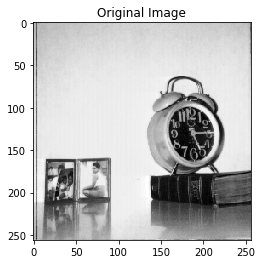

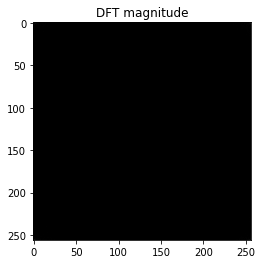

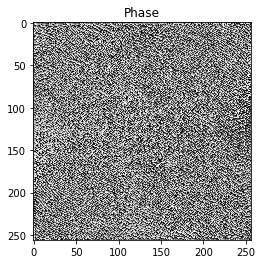

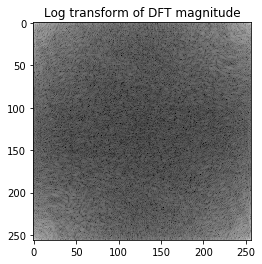

In [7]:
image = read_image(PATH1)
plot_image(image, 'Original Image')
image_dft = fft(image)
magnitude = np.abs(image_dft)
phase = np.angle(image_dft)
plot_image(magnitude, 'DFT magnitude')
plot_image(phase, 'Phase')
plot_image(log_transform(magnitude), 'Log transform of DFT magnitude', show=True)

## Part-II
2. Generate the centered DFT using `((− 1)^(i + j))I` and display its magnitude.

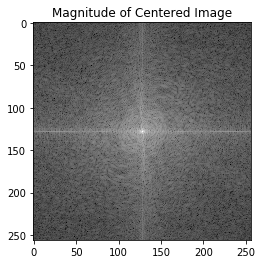

In [8]:
centered_dft = get_centered_dft(image)
plot_image(log_transform(np.abs(centered_dft)), 'Magnitude of Centered Image', show=True)

## Part-II
3. Verify that `IDFT[DFT[I]] = I`

In [9]:
assert np.allclose(image, ifft((fft(image))))
print('Hence Proved (Matrix multiplication DFT)')

cropped_image = image[:32, :32]
assert np.allclose(cropped_image, idft((dft(cropped_image))))
print('Hence Proved (Naive DFT)')

Hence Proved (Matrix multiplication DFT)
Hence Proved (Naive DFT)


## Part-II
4. Show the importance of phase by transposing the phase matrix and then synthesizing the image. Repeat by  
a) setting the phase to 0  
b) by adding noise.

In [10]:
def synthesize_image(magnitude: np.ndarray, phase: np.ndarray):
    """Construct Image from Magnitude and Phase of Image"""
    assert magnitude.shape == phase.shape
    return ifft(np.cos(phase) * magnitude + 1j * np.sin(phase) * magnitude) 

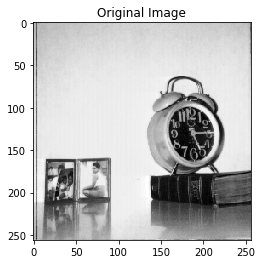

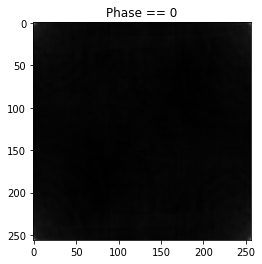

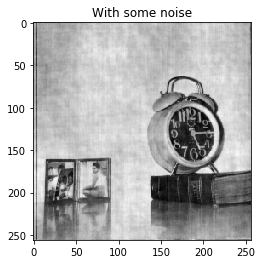

In [11]:
plot_image(image, title='Original Image')
plot_image(synthesize_image(magnitude, np.zeros(phase.shape)), title='Phase == 0')
plot_image(synthesize_image(magnitude, phase + np.random.rand(*phase.shape)), title='With some noise', show=True)

# 2 Periodic Convolution

## 2.1 
Circulary convolve two images. Test your program by using an image and an averaging filter of size 5 × 5. (5)


In [12]:
def round_index(i: int, j: int, N: int, M: int):
    return (i % N, j % M)

def circular_convolve(I1: np.ndarray, I2: np.ndarray):
    """Perform Circular Convolution (Naive Implementation)

    Args:
        I1: `np.ndarray`, Image for Circular Convolution
        I2: `np.ndarray`, filter of for Circular Convolution

    Returns: `np.ndarray`, Image after transformation.    
    """
    N, M = I1.shape
    P, Q = I2.shape

    J = np.zeros((N, M))
    for i in range(J.shape[0]):
        for j in range(J.shape[1]):
            for p in range(P):
                for q in range(Q):
                    J[i][j] += I1[round_index(i - p, j - q, N, M)] * I2[p][q]
    return J

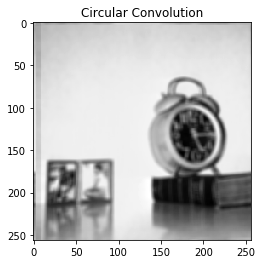

In [13]:
averaging_filter = np.ones((5, 5))/25
circular_convolve_img = circular_convolve(image, averaging_filter)
plot_image(circular_convolve_img, 'Circular Convolution', show=True)

In [14]:
def circular_convolve_with_dft(I1: np.ndarray, I2: np.ndarray):
    """Perform Circular Convolution (Using DFT)

    Args:
        I1: `np.ndarray`, Image for Circular Convolution
        I2: `np.ndarray`, filter of Circular Convolution

    Returns: `np.ndarray`, Image after transformation.    
    """
    N, M = I1.shape
    P, Q = I2.shape
    I2_padded = np.zeros((N, M))
    I2_padded[:P, :Q] = I2
    return ifft(fft(I1) * fft(I2_padded))

circular_convolve_dft = circular_convolve_with_dft(image, averaging_filter)

assert np.allclose(circular_convolve_dft, circular_convolve_img)
print('Hence Proved')

Hence Proved


## 2.2 
Linearly convolve the same image and filter using the circular convolution function above after appropriate
zero padding.


In [15]:
def linear_convolve(I1: np.ndarray, I2: np.ndarray):
    """Perform Linear Convolution (Naive Implementation)

    Args:
        I1: `np.ndarray`, Image for Linear Convolution
        I2: `np.ndarray`, filter of Linear Convolution

    Returns: `np.ndarray`, Image after transformation.    
    """

    N, M = I1.shape
    P, Q = I2.shape

    I1_padded = np.zeros((2 * N, 2 * M))
    I1_padded[:N, :M] = I1
    I2_padded = np.zeros((2 * P, 2 * Q))
    I2_padded[:P, :Q] = I2 
    return circular_convolve(I1_padded, I2_padded)[:N + P - 1, :M + Q - 1]

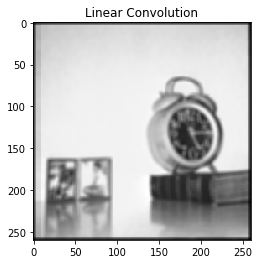

In [16]:
linear_convolve_img = linear_convolve(image, averaging_filter)
plot_image(linear_convolve_img, 'Linear Convolution', show=True)

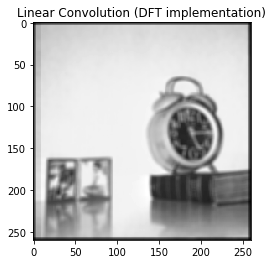

In [17]:
def linear_convolve_with_dft(I1: np.ndarray, I2: np.ndarray):
    """Perform Linear Convolution (using DFT)

    Args:
        I1: `np.ndarray`, Image for Linear Convolution
        I2: `np.ndarray`, filter of Linear Convolution

    Returns: `np.ndarray`, Image after transformation.    
    """

    N, M = I1.shape
    P, Q = I2.shape
    I1_padded = np.zeros((2 * N, 2 * M))
    I1_padded[:N, :M] = I1
    I2_padded = np.zeros((2 * N, 2 * M))
    I2_padded[:P, :Q] = I2
    return ifft(fft(I1_padded) * fft(I2_padded))[:N + P - 1, :M + Q - 1]

linear_convolve_dft = linear_convolve_with_dft(image, averaging_filter)
plot_image(linear_convolve_dft, 'Linear Convolution (DFT implementation)', show=True)

## 2.3 
Now, verify that you can perform linear covolution using the DFT of zero padded images.

In [18]:
assert np.allclose(linear_convolve_dft, linear_convolve_img)
print('Hence Proved')

Hence Proved


# 3 Image Denoising using Linear Filters

In [19]:
mean = 0
std = 25
noisy_image = image + np.random.normal(mean, std, image.shape)

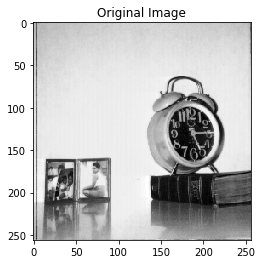

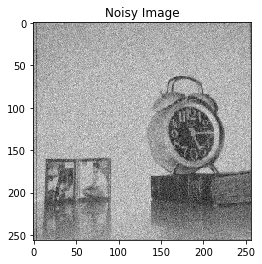

In [20]:
plot_image(image, title='Original Image')
plot_image(noisy_image, title='Noisy Image', show=True)

## 3.1 
Average filter of size M × M. Vary M from 3 to 15 in increments of 2 and observe the tradeoff between denoising and smoothing. What could be an appropriate window size for this noise level?


Ans: In my opinion, Average Filter with smaller size denoise the image comparatively better.

Larger filters blacken the borders. Hence, useful information is lost.  
Moreover, bluriness increases with the size of filter.


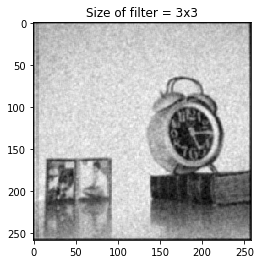

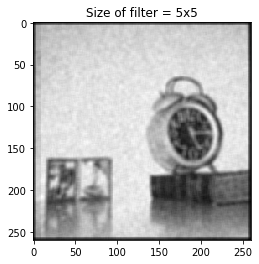

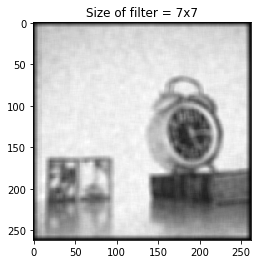

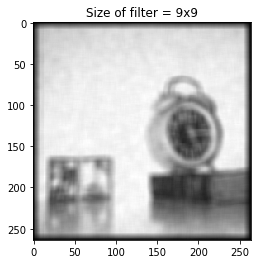

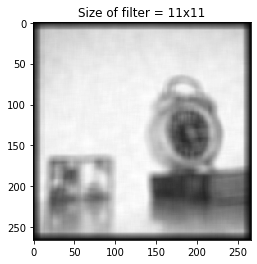

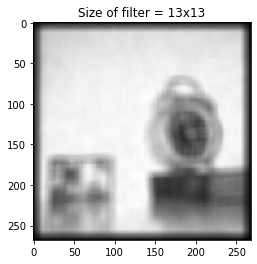

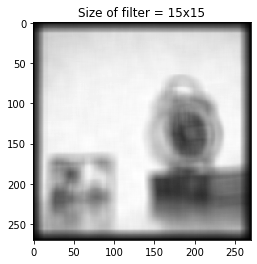

In [21]:
for m in range(3, 16, 2):
    averaging_filter = np.ones((m, m))/(m * m)
    plot_image(linear_convolve_with_dft(noisy_image, averaging_filter), title=f'Size of filter = {m}x{m}')

In [22]:
def gaussian_filter(std, shape=(5,5)):
    """Get Gaussian filter with given Standard Deviation and shape.

    Args:
        std: `int`, Standard Deviation
        I2: `Tuple[int, int]`, Shape of filter

    Returns: `np.ndarray`, Gaussian filter.    
    """

    c = -2 * np.pi * std * std
    gfilter = np.array([[c * (i*i + j*j)/ (shape[0]*shape[1]) for j in range(shape[1])]for i in range(shape[0])])
    return np.exp(gfilter)

## 3.2
Gaussian filter of size 5 × 5. Experiment with the standard deviation σ h of the filter from 0.5 to 5 in steps of 0.5 and observe its effect on denoising.

Ans: In my opinion, Gaussian Filter with STD = 2 produces the best image.

For STD < 2, the image is comparatively blur.  
For STD > 2, the image becomes noiser.

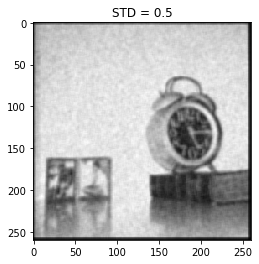

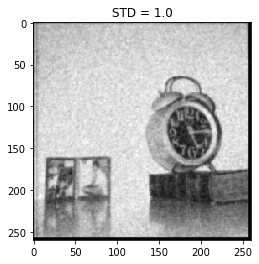

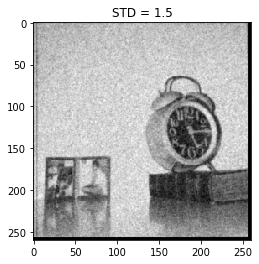

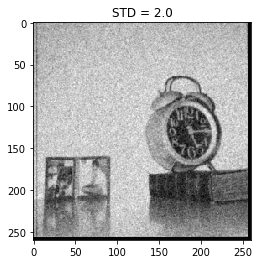

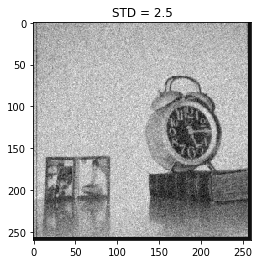

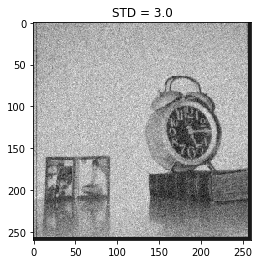

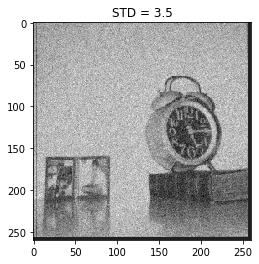

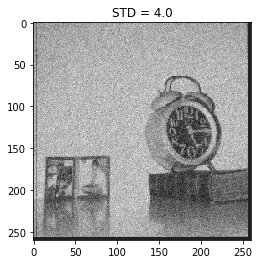

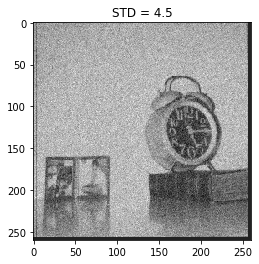

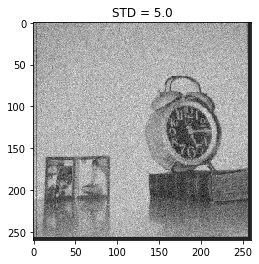

In [23]:
for i in range(1, 11):
    std = i * 0.5
    averaging_filter = gaussian_filter(std)
    plot_image(linear_convolve_with_dft(noisy_image, averaging_filter), title=f'STD = {std}')